# Flat roof classification

The goal of this research is to develop a method of identifying whether a building has a *flat roof*. The identification is based on the height values of the respective building's point cloud. The restriction of *height values only* comes from the implemention of 3dfier, where the current method will be added. The images below illustrate which buildings are considerd to have *flat roofs* and which do not. The distinction is based on the results of a small, informal survey on what do people consider as a *flat roof*, see [the results](https://docs.google.com/spreadsheets/d/1MCIlkuERx6AqcNYZjpnWm-oCBLAXiXhH11Li1WbGOVU/edit?usp=sharing).

## Flat roofs

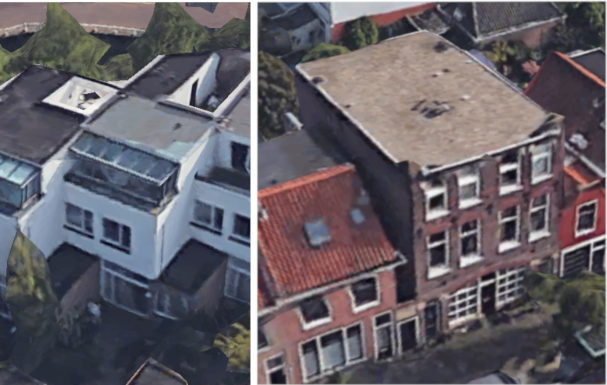

## Not-flat roofs

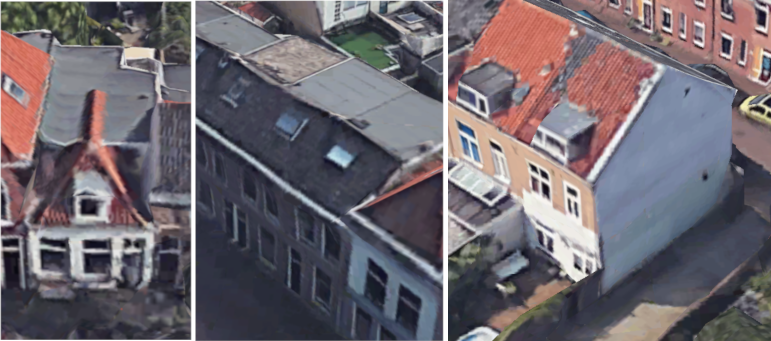

In [18]:
library(dplyr)
library(tidyr)
library(ggplot2)

Read the data

In [19]:
dat <- read.csv("data/delft_all-z.csv",
                sep = ",", stringsAsFactors = FALSE, header = FALSE,
                skip = 1)
dat <- dat[,c(1,2)]
names(dat) <- c("gml_id","allz")

#do <- read.csv("data/delft_oostport.csv", stringsAsFactors = FALSE)
#dt <- read.csv("data/delft_topdesk.csv", stringsAsFactors = FALSE)
#roof_flat <- bind_rows(do, dt)
roof_flat <- read.csv("data/delft_testarea.csv", stringsAsFactors = FALSE)

Initially I classified roofs as *0 - not flat*, *1 - flat*, *2 - in-between* to indicate the dubious cases in the validation set. But for the current method the *in-between*s are also considered *not flat*.

In [20]:
roof_flat[roof_flat$roof_flat == 2, "roof_flat"] <- 0
roof_flat$roof_flat  <- factor(roof_flat$roof_flat, labels = c("Not flat", "Flat"))

In [21]:
# parse the output of CSV-BUILDINGS-MULTIPLE
parse_allz  <- function(x) {
    return(as.numeric(strsplit(x, "|", fixed = TRUE)[[1]]))
}
allz  <- list()
for (n in dat$gml_id) allz[[n]]  <- parse_allz(dat[dat$gml_id == n, "allz"]) # create a named list

rm(dat)

The amount of *flat* and *not flat* roofs:

In [22]:
table(roof_flat$roof_flat)
print(paste("Sample size:", nrow(roof_flat)))


Not flat     Flat 
     274      208 

[1] "Sample size: 482"


## Data preprocessing

Buildings come in all shapes and sizes, furthermore the point coverage is not uniform across building parts (walls, roof) and buildings. Therefore it is important to normalize the height values to a uniform range. Say $min_A$ and $max_A$ are the minimum and maximum height values in building $A$, then **min-max normalization** maps a value $v_i$ of $A$ to $v_i^{'}$ in the range $\lbrack new\_min_A, new\_max_A \rbrack$ by computing

$$v_i^{'} = \frac{v_i - min_A}{max_A - min_A}(new\_max_A - new\_min_A) + new\_min_A$$

In [23]:
mm_norm <- function(x, new_min, new_max) {
    mi <- min(x)
    mx <- max(x)
    return(( (x - mi) / (mx - mi) ) * (new_max - new_min) + new_min)
}

We normalize the height values on the range $\lbrack 0,1 \rbrack$, which is an arbitrary choice. Occaisonally the function cannot return a value and thus these `NA` (not available) need to be omitted. Because we have a large amounts of available points, removing the `NA`-s does not hinder the further process.

In [24]:
allz_norm <- na.omit(lapply(allz, mm_norm, new_min=0, new_max=1))
allz_norm[1]
allz_norm <- allz

$`b31e1feb1-00ba-11e6-b420-2bdcc4ab5d7f`
 [1] 0.000000000 0.000000000 0.000000000 0.004081633 0.004081633 0.008163265
 [7] 0.008163265 0.008163265 0.008163265 0.008163265 0.012244898 0.028571429
[13] 0.048979592 0.061224490 0.061224490 0.073469388 0.089795918 0.106122449
[19] 0.179591837 0.310204082 0.730612245 0.775510204 0.897959184 0.959183673
[25] 0.959183673 0.959183673 0.959183673 0.959183673 0.963265306 0.963265306
[31] 0.963265306 0.963265306 0.963265306 0.963265306 0.963265306 0.963265306
[37] 0.963265306 0.963265306 0.963265306 0.963265306 0.963265306 0.963265306
[43] 0.963265306 0.963265306 0.963265306 0.963265306 0.967346939 0.967346939
[49] 0.967346939 0.967346939 0.967346939 0.967346939 0.967346939 0.967346939
[55] 0.967346939 0.967346939 0.967346939 0.967346939 0.967346939 0.967346939
[61] 0.967346939 0.971428571 0.971428571 0.971428571 0.971428571 0.971428571
[67] 0.971428571 0.971428571 0.975510204 0.975510204 0.975510204 0.975510204
[73] 0.979591837 0.983673469 0.987755102 0.991836735 0.991836735 0.995918367
[79] 0.995918367 0.995918367 0.995918367 0.995918367 1.000000000 1.000000000
[85] 1.000000000 1.000000000

In [25]:
save.image(file = "data/flat_roofs.RData")

## Basic descriptive statistics

We compute basic statistics which describe the distribution of the height values. These include the *five-number summary* such as *minimum*, *quartile Q_1*, *median*, *quartile Q_3*, *maximum*, and *mean*, *standard deviation*.

In [65]:
# returns a data frame
add_stats <- function(allz, roof) {
    o <- roof
    for (id in names(allz)) {
        o[o$gml_id == id, "min"] <- min(allz[[id]])
        o[o$gml_id == id, "q1"] <- quantile(allz[[id]], probs = 0.25)[[1]]
        o[o$gml_id == id, "median"] <- median(allz[[id]])
        o[o$gml_id == id, "q3"] <- quantile(allz[[id]], probs = 0.75)[[1]]
        o[o$gml_id == id, "max"] <- max(allz[[id]])
        o[o$gml_id == id, "sd"] <- sd(allz[[id]])
        o[o$gml_id == id, "mean"] <- mean(allz[[id]])
    }
    return(o)
}

In [66]:
allz_stats <- add_stats(allz_norm, roof_flat)
head(allz_stats)

gml_id,roof_flat,min,q1,median,q3,max,sd,mean
b31e1feb1-00ba-11e6-b420-2bdcc4ab5d7f,Flat,0,0.3795918,0.9632653,0.9714286,1,0.3954001,0.7357945
b31bc26a8-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,0,0.3052838,0.7328767,0.8674168,1,0.3008047,0.6250625
b31bdfb7f-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,0,0.6218441,0.8188804,0.9099890,1,0.2687123,0.7241466
b31be49eb-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,0,0.8089511,0.8726341,0.9148265,1,0.1983630,0.8085738
b31bbd90d-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,0,0.4718148,0.5797434,0.6670486,1,0.1970396,0.5370839
b112715ef-00ba-11e6-b420-2bdcc4ab5d7f,Not flat,0,0.3987437,0.7909548,0.8914573,1,0.3302432,0.6396320


Warning message:
“Removed 3 rows containing missing values (geom_point).”

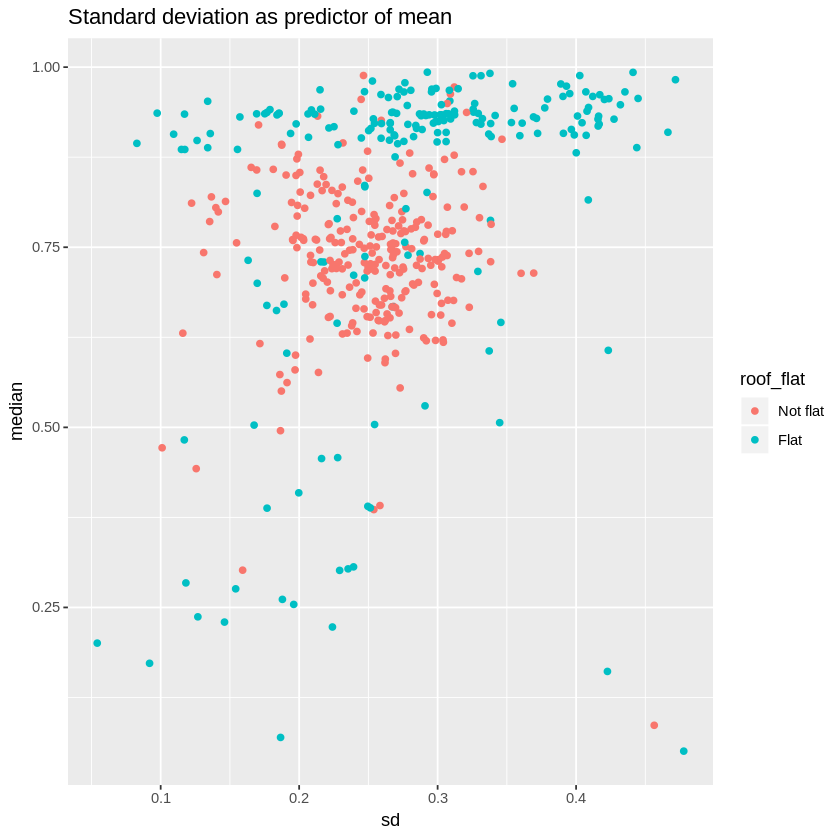

In [67]:
ggplot(allz_stats, aes(x = sd, y = median, color = roof_flat)) +
    geom_point() +
    labs(title = "Standard deviation as predictor of mean")

Warning message:
“Removed 3 rows containing missing values (geom_point).”

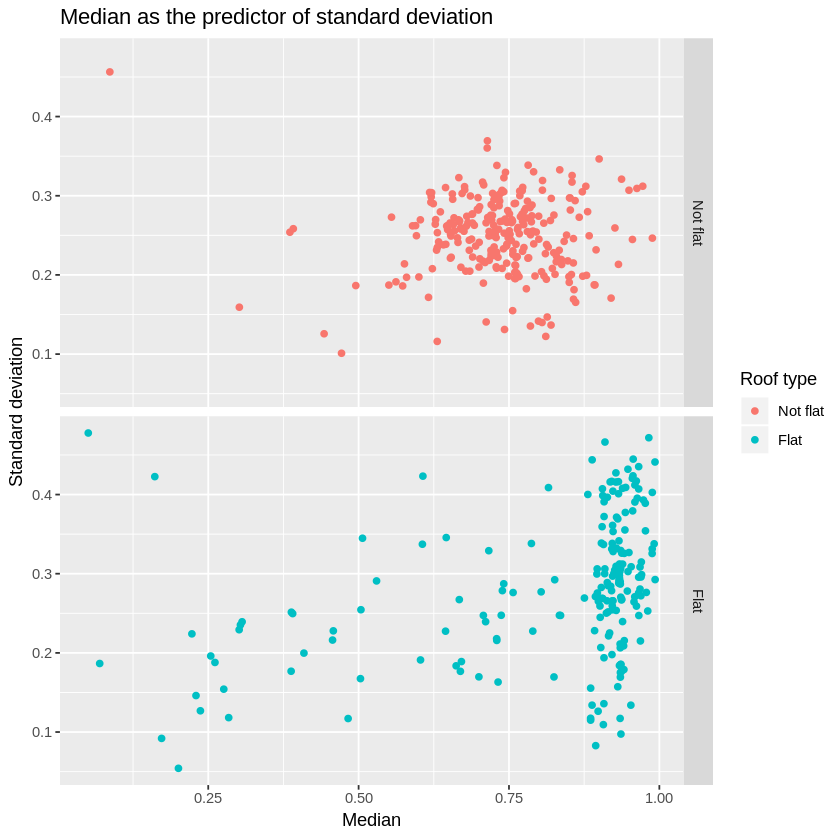

In [68]:
ggplot(allz_stats, aes(x = median, y = sd, color = roof_flat)) +
    geom_point() +
    facet_grid(rows = vars(roof_flat)) +
    labs(title = "Median as the predictor of standard deviation",
        color = "Roof type", x = "Median", y = "Standard deviation")

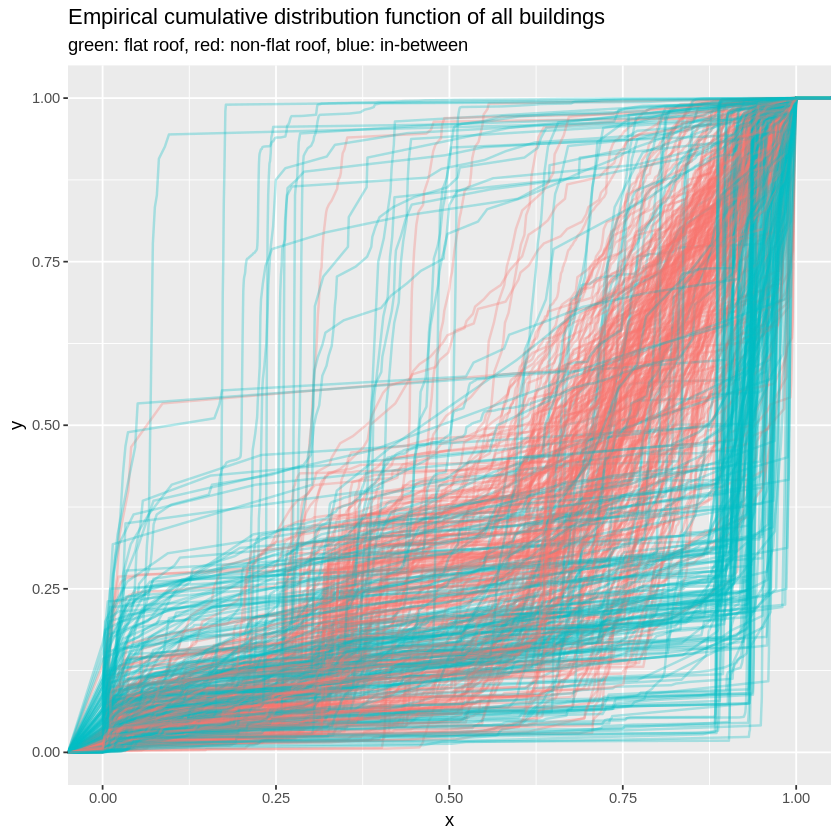

In [72]:
p_ecdf <- ggplot() + labs(title = "Empirical cumulative distribution function of all buildings",
                         subtitle = "green: flat roof, red: non-flat roof, blue: in-between")
for (id in names(allz_norm)) {
    f <- as.character(roof_flat[roof_flat$gml_id == id, "roof_flat"])
    if (length(f) > 0) {
        if (f == 'Not flat') {col <- "#f8766d"}
        else if (f == 'Flat') {col <- "#00bfc4"}
        p_ecdf <- p_ecdf + stat_ecdf(data = data.frame(x = allz_norm[[id]]), 
                                     aes(x), geom = "path", 
                                     color = col, alpha = 0.3, size = 0.7)
    }
}
p_ecdf

## Clustering

### k-means clustering

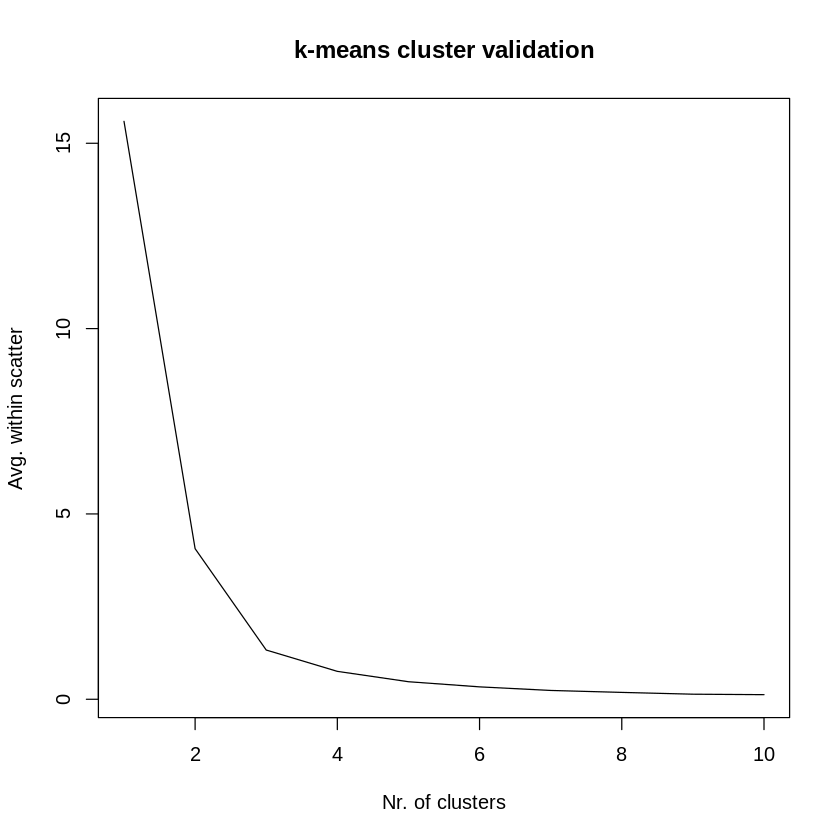

In [73]:
set.seed(20)
s <- na.omit(allz_stats[, c("roof_flat","sd", "median")])
nr_cluster <- seq(1,10)
s_within <- as.numeric()
for (i in nr_cluster) {
    zClust <- kmeans(s[, c("sd", "median")], i, nstart = 20)
    s_within <- c(s_within, sum(zClust$withinss) / i)
}

plot(nr_cluster, s_within, "l", xlab = "Nr. of clusters", ylab = "Avg. within scatter", 
     main = "k-means cluster validation")

3-4 clusters seem like a good number, but let's do 2 as we have 2 roof categories labelled.

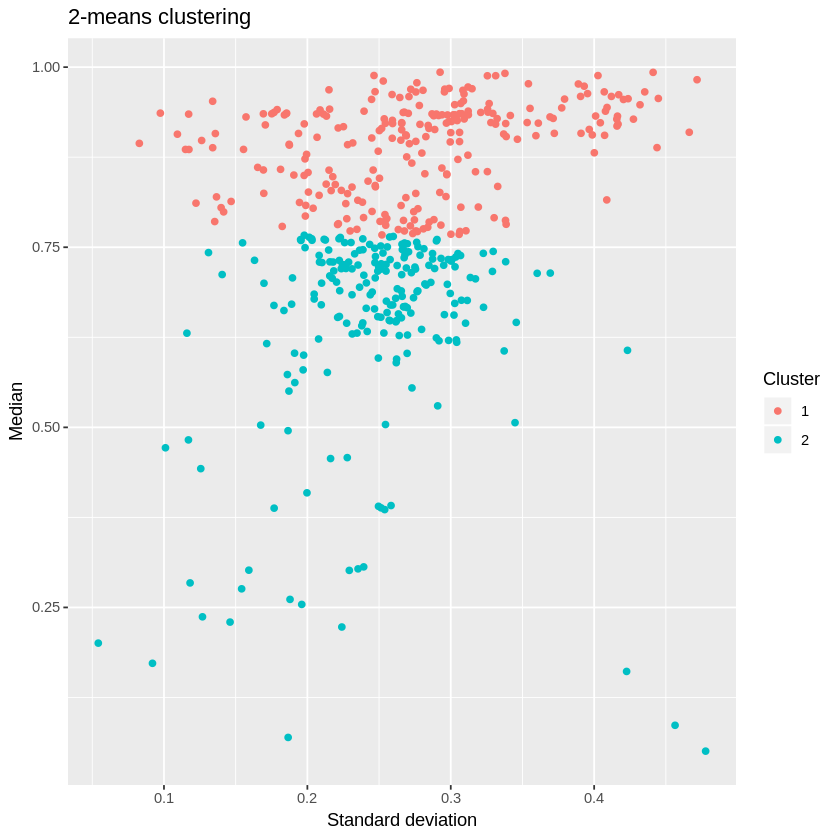

In [80]:
k <- 2
zClust <- kmeans(s[, c("sd", "median")], k, nstart = 20)
zClust$cluster <- as.factor(zClust$cluster)
ggplot(s, aes(sd, median, color = zClust$cluster)) + geom_point() + 
    labs(title = paste0(k,"-means clustering"), y = "Median", x = "Standard deviation", color = "Cluster")

Then the confusion matrix:

In [81]:
table(zClust$cluster, s$roof_flat)

   
    Not flat Flat
  1       98  159
  2      173   46

### Hierarchical clustering

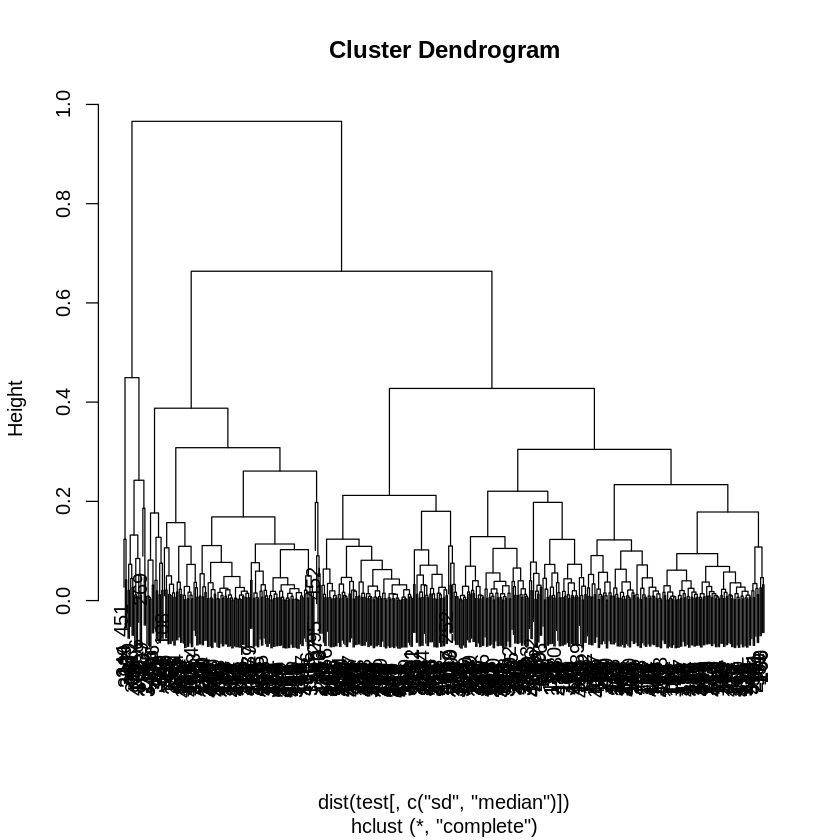

In [96]:
test <- na.omit(allz_stats)
hc  <- hclust(dist(test[, c("sd", "median")]), method = "complete")
plot(hc)

Its best to cut the tree at 2 or 3 clusters, but as we used 2 clusters for the k-means, we'll cut the tree at 2 clusters too.

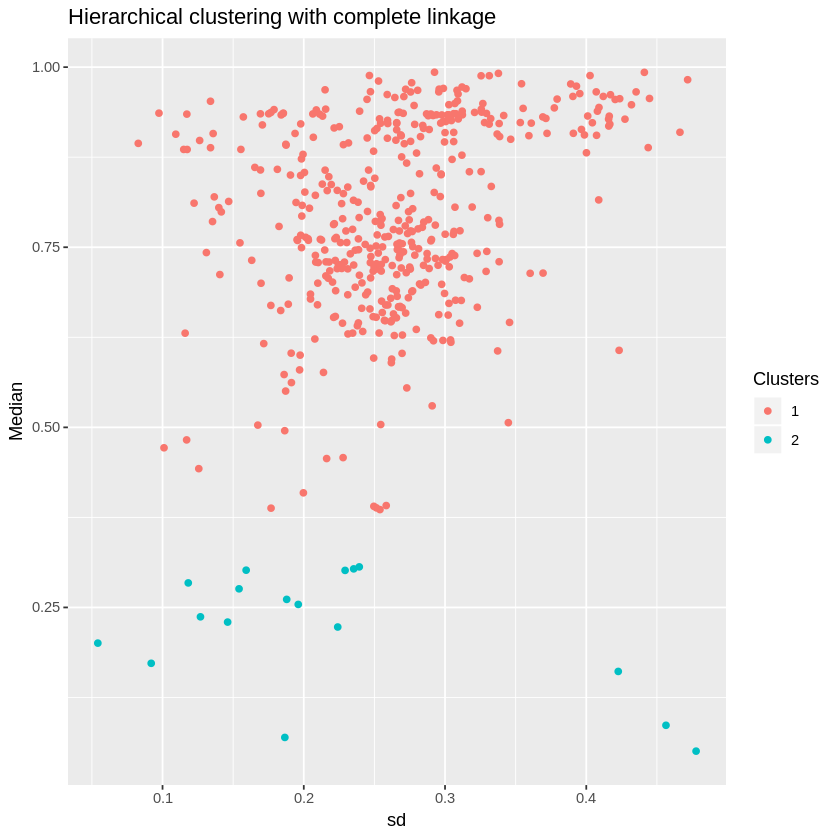

In [99]:
clusters <- 2
clustercut <- cutree(hc, clusters)
ggplot(test[, c("sd", "median")], aes(sd, median, color = as.factor(clustercut))) +
    geom_point() +
    labs(title = "Hierarchical clustering with complete linkage",
        color = "Clusters", y = "Median", "Standard deviation")